In [1]:
# 导入包
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# 定义拼接类
class Stitcher:
    def stitch(self, images, ratio=0.6, reprojThresh=4.0, showMatches=False):
        # 获取输入图片
        (imageB, imageA) = images
        # 检测A、B图片的SIFT关键特征点，并计算特征描述子
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 匹配两张图片的所有特征点，返回匹配结果
        M = self.matchKeypoints(kpsA, kpsB, featuresA,
                                featuresB, ratio, reprojThresh)

        # 如果返回结果为空，没有匹配成功的特征点，退出算法
        if M is None:
            return None

        # 否则，提取匹配结果
        # H是3x3视角变换矩阵
        (matches, H, status) = M
        # 将图片A进行视角变换，result是变换后图片
        result = cv2.warpPerspective(
            imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))

        # 融合
        for r in range(result.shape[0]):
            left = 0
            for c in range(result.shape[1]//2):
                if result[r, c].any():  # overlap
                    if left == 0:
                        left = c
                    alpha = (c-left)/(result.shape[1]//2-left)
                    result[r, c] = imageB[r, c]*(1-alpha) + result[r, c]*alpha
                else:
                    result[r, c] = imageB[r, c]

        # 检测是否需要显示图片匹配
        if showMatches:
            # 生成匹配图片
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # 返回结果
            return (result, vis)

        # 返回匹配结果
        return result

    # 检测图片的关键点并且提取局部不变特征
    # 使用高斯差分关键点检测和SIFT特征提取
    def detectAndDescribe(self, image):
        # 将彩色图片转换成灰度图
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 建立SIFT生成器
        descriptor = cv2.SIFT_create()
        # 检测SIFT特征点，并计算描述子
        (kps, features) = descriptor.detectAndCompute(gray, None)

        # 将结果转换成NumPy数组
        kps = np.float32([kp.pt for kp in kps])

        # 返回特征点集，及对应的描述特征
        return kps, features

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.DescriptorMatcher_create("BruteForce")

        # 使用KNN检测来自A、B图的SIFT特征匹配对，K=2
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # 当最近距离跟次近距离的比值小于ratio值时，保留此匹配对
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                # 存储两个点在featuresA, featuresB中的索引值
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 当筛选后的匹配对大于4时，计算视角变换矩阵
        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算视角变换矩阵
            (H, status) = cv2.findHomography(
                ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # 返回结果
            return (matches, H, status)

        # 如果匹配对小于4时，返回None
        return None

    # 将两幅图片中的匹配点连线
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 初始化可视化图片，将A、B图左右连接到一起
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 联合遍历，画出匹配对
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # 当点对匹配成功时，画到可视化图上
            if s == 1:
                # 画出匹配对
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # 返回可视化结果
        return vis


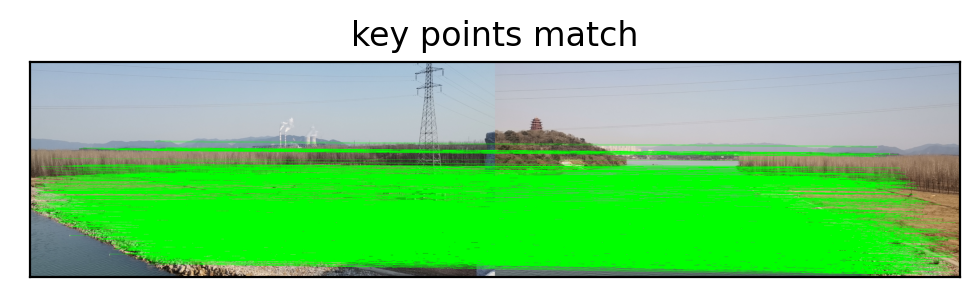

In [3]:
if __name__ == '__main__':
    imageL = cv2.imread("./3.jpg")
    imageR = cv2.imread("./4.jpg")
    stitcher =Stitcher()
    (result,vis)=stitcher.stitch([imageL,imageR],showMatches=True)

    # 设置分辨率
    plt.figure(dpi=200)
    # 隐藏x轴和y轴
    plt.xticks([])
    plt.yticks([])
    plt.title("key points match")
    plt.imshow(vis[...,::-1])
    plt.show()

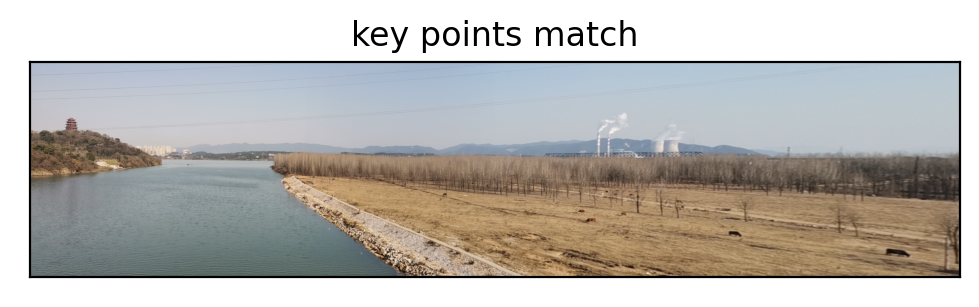

In [4]:
plt.figure(dpi=200)
plt.title("key points match")
plt.xticks([])
plt.yticks([])
plt.imshow(result[..., ::-1])
plt.show()
